# PyTorch Paper Replicating 

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-george-hotz-quote.png)

In this notebook, we're going to replicate the results of paper [ *An Image is worth 16x16 words: Transformers for Image Recognition at Scale* ]. <br> <br>

<b>Abstract:</b> <br>
While the Transformer architecture has become the de-facto standard for natural <br>
language processing tasks, its applications to computer vision remain limited. In <br>
vision, attention is either applied in conjunction with convolutional networks, or <br>
used to replace certain components of convolutional networks while keeping their <br>
overall structure in place. We show that this reliance on CNNs is not necessary <br>
and a pure transformer applied directly to sequences of image patches can perform <br>
very well on image classification tasks. When pre-trained on large amounts of <br>
data and transferred to multiple mid-sized or small image recognition benchmarks <br>
(ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent <br>
results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train. <br>

**Orginal Paper** : [An Image is worth 16x16 words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) <br>




# 0. Getting started

Importing all the necessary libraries and create all the helper functions that we will use throughout the notebook.

In [1]:
import os 
import sys
sys.path.append('../2.Going_Modular/') 

In [2]:
from pathlib import Path
import zipfile
import requests
from going_modular import data_setup, engine #type: ignore

import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary

import matplotlib.pyplot as plt

HyperParameters:

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
NUM_WORKERS = 4
NUM_WORKERS


4

Different Helper function definatinos are as follows:

In [6]:
def set_seeds(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



# 1. Get the Data

In [10]:
#downloading same pizza_steak dataset
data = Path("data")
image_path =  data/ "pizza_steak_sushi"

if image_path.exists():
    print(f"{image_path} already exists")
else:
    image_path.mkdir( parents=True, exist_ok=True)
    
    with open(image_path/'pizza_steak_sushi.zip', 'wb') as f:
        print("Downloading pizza_steak_sushi.zip . . .")
        url ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        response = requests.get(url)
        f.write(response.content)
        print('suceessfully downloaded pizza_steak_sushi.zip')
    
    with zipfile.ZipFile(image_path/'pizza_steak_sushi.zip','r') as ref:
        ref.extractall(image_path)
    
    os.remove(image_path/'pizza_steak_sushi.zip')
        

data\pizza_steak_sushi already exists


In [11]:
# Create path to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Dataloader


In [13]:
#Prepare the trasnforms for images

IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [14]:
# Using ImageFolder to load in data
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(root=train_dir, # type: ignore
                                  transform=manual_transform)
test_data = datasets.ImageFolder(root=test_dir, # type: ignore
                                 transform=manual_transform)
class_names = train_data.classes

train_dataloader = DataLoader(train_data,
        batch_size= BATCH_SIZE,
        shuffle= True, 
        num_workers= NUM_WORKERS,
        pin_memory= True
       )
test_dataloader = DataLoader(test_data,
        batch_size= BATCH_SIZE,
        shuffle= True, 
        num_workers= NUM_WORKERS,
        pin_memory= True
       )

In [9]:
#Visualize a single image

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

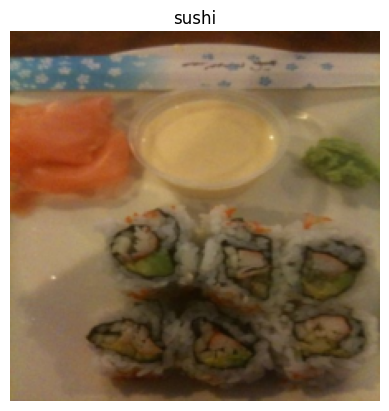

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

# 3. Replicating the ViT paper

* **Layer** - takes an input, performs a function on it, returns an output. <br>
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.<br>
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output<br>

These are the several stages that ViT architecture is compirse of: <br>


| Layer | Description |
| --- | --- |
| Patch + Position Embedding (inputs) | Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in. |
| Linear projection of flattened patches (Embedded Patches) | The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training. |
| Norm | This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm(). |
| Multi-Head Attention | This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention(). |
| MLP (or Multilayer perceptron) | A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1). |
| Transformer Encoder | The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother. |
|MLP Head| This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classification head". The structure of the MLP Head is similar to the MLP block. |


These four equation are the main components of the ViT architecture. <br>
$$
\begin{align}
\mathbf{z}_0 &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text{pos}}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1) \times D} \tag{i} \\
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L \tag{ii} \\
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L \tag{iii} \\
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_L^0\right) \tag{iv}
\end{align}
$$

## 3.1 Equation ( i )

#### **1. Overview:**
* This equation initializes the input sequence for the Vision Transformer (ViT) model.
* It consists of three main components:
    - Class token ( $\mathbf{x}_{\text {class }}$ )
    - Patch embeddings ($\mathbf{x}_p^iE$)
    - Position embeddings ($\mathbf{E_{pos}}$)
The equation combines these componensts to form the input sequence $z_0$.<br>

#### **2. Explanation of Terms:** <br>

**Class Token ($x_{class}$):**<br>
* $x_{class}$ is a special token added at the beginning of the input sequence.
* It is similar to the [CLS] token used in NLP Transformers (like BERT).
* This token is used to aggregate information from all image patches and is typically used for classification tasks.
* During the forward pass, the final representation of this token is used to predict the class of the input image.<br>

**Patch Embeddings ($x_p^iE$):**<br>
* The input image is divided into N non-overlapping patches, each of size $P \times P$.
* $x_p^i$ represents the flattened pixel values of the i-th patch.
* $E$ is the embedding matrx of size $\mathbb{R}^{\left(P^2 \cdot C\right)\times D}$
    * $P^2$ is the number of pixels in a patch {eg. if path size is 16x16, then $P^2 = 16*16 = 256$}
    * $C$ is the number of color channels in the input image.
    * $D$ is the dimension of the embedding space.
* Each pathc $x_p^i$ is projected using the matrix $E$ to obtain a D-dimensional embedding $x_p^iE$.<br>

**Position Embeddings ($E_{pos}$):**<br>
* $E_{pos}$ is the position embedding matrix of size $\mathbb{R}^{(N+1) \times D}$.
    * $N$ is the total number of patches in the input image.
    * +1 accounts for the class token, making a total of N+1 tokens in the input sequence.
* Position embedding provide information about the order of the tokens, which is crucial because Transformers are inherently permuation invariant. <br>

#### **3. Constructing the Input Sequence ($z_0$):** <br>
* The input sequence $z_0$ is constructed by concatenating:
    - The class token $x_{class}$
    - The patch embeddings $x_p^iE$ for each patch
* Then, the position embeddings $E_{pos}$ are added element-wise to the concatenated sequence to form the final input sequence $z_0$.<br>

### **Equation Summary:**
$\mathbf{z}_0=\underbrace{\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]}_{\text {Concatenation of class token and patch embeddings }}+\underbrace{\mathbf{E}_{\text {pos }}}_{\text {Position embeddings }}$

### **Example:**
lets say: <br>
- Image size : 224x224
- Patch size : 16x16
- Number of patches(N) : $(224/16)^2$ = 196
- Embedding dimension (D) : 768

Then, the input sequence $z_0$ will have the following dimensions:
- Total tokens: 196 (patches) + 1 (class token) = 197
- Each token has an Embedding dimension: 768




## 3.2 Equation ( ii )


$
\begin{align}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L \tag{ii}
\end{align}
$

#### **1. Overview:**:
* This equation represents the Multi-Head Self-Attention (MSA) layer in the Vision Transformer (ViT) model.
* The MSA layer is a key component of the Transformer architecture and is used to capture the relationships between different tokens in the input sequence.
* The output of the MSA layer is the input to the next layer in the ViT model.

#### **2. Explanation of Terms:** <br>

**Layer Normalization (LN):**<br>
* LN is a normalization technique used to stabilize the training of neural networks.
* It normalizes the input tensor across the feature dimension.
* The output of the LN layer is used as the input to the MSA layer.<br>

**Multi-Head Self-Attention (MSA):**<br>
* MSA is a mechanism that allows each token in the input sequence to attend to other tokens.
* It computes the attention scores between all pairs of tokens and uses them to update the token representations.

#### **3. MSA Layer:** <br>
* The input to the MSA layer is the output of the LN layer from the previous layer.
* The MSA layer computes self-attention scores between all tokens in the input sequence.
* The self-attention scores are used to compute the attention weights, which are then used to update the token representations.
* The output of the MSA layer is the sum of the input to the MSA layer and the updated token representations.


### **Example:**
- Input to MSA layer: $\mathbf{z}_{\ell-1}$ (output of the previous layer)
- Output of MSA layer: $\mathbf{z}_{\ell}^{\prime}$ (updated token representations)





## 3.3 Equation ( iii )

$
\begin{align}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L \tag{iii} \\
\end{align}
$

#### **1. Overview:**:
* This equation represents the Multi-Layer Perceptron (MLP) block in the Vision Transformer (ViT) model.
* The MLP block consists of two linear layers with a GELU activation function in between them.
* The output of the MLP block is the input to the next layer in the ViT model.

#### **2. Explanation of Terms:** <br>

**Layer Normalization (LN):**<br>
* LN is a normalization technique used to stabilize the training of neural networks.
* It normalizes the input tensor across the feature dimension.
* The output of the LN layer is used as the input to the MLP block.<br>

**Multi-Layer Perceptron (MLP):**<br>
* The MLP block consists of two linear layers with a GELU activation function in between them.
* The first linear layer projects the input tensor to an intermediate dimension.
* The GELU activation function introduces non-linearity to the model.
* The second linear layer projects the tensor back to the original dimension.

#### **3. MLP Block:** <br>
* The input to the MLP block is the output of the LN layer from the previous layer.
* The MLP block consists of two linear layers with a GELU activation function in between them.
* The output of the MLP block is the sum of the input to the MLP block and the output of the second linear layer.



## 3.4 Equation ( iv )

$
\begin{align}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_L^0\right) \tag{iv}
\end{align}
$

#### **1. Overview:**:
* This equation represents the final output of the Vision Transformer (ViT) model.
* The output is obtained by applying Layer Normalization (LN) to the final token representation.

#### **2. Final Output:** <br>
* The final output of the ViT model is obtained by applying Layer Normalization to the final token representation.
* The final token representation is the output of the last layer in the ViT model.


## 3.5 Implementing Equation ( i )

* Input shape: (height x width x color channels)
* Output shape: $N * (P^2.C)$ 
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = $(height * width) / P^2$
* D = constant latent vector size = embedding dimension 

### 3.5.1 Calculating patch embedding input and output shapes by hand

In [11]:
height = 224
width  = 224
color_channels = 3
patch_size =16

n_patches = int(((height*width)/patch_size**2)) # or ((height)/(patch_size))^2

print(f"Number of patches : {n_patches}")

Number of patches : 196


In [12]:
# Defining input and output shapes of patch embedding layer

embedding_layer_input_shape = (height,width,color_channels)

embedding_lauer_output_shape = (n_patches, patch_size**2*color_channels)

print(f"Input shape [2D image]: {embedding_layer_input_shape}")
print(f"Output shape [2D image flattened into patches]: {embedding_lauer_output_shape}")




Input shape [2D image]: (224, 224, 3)
Output shape [2D image flattened into patches]: (196, 768)


### 3.5.2 Turning a single image into patches

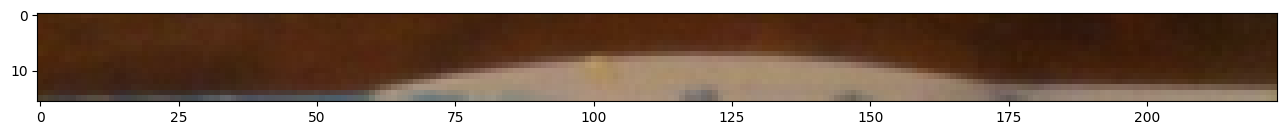

In [13]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:]) #plotting top rows of image
plt.show()

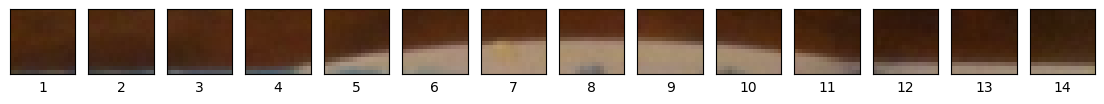

In [14]:
# turning top row of image into patches

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                        ncols=int(num_patches),
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


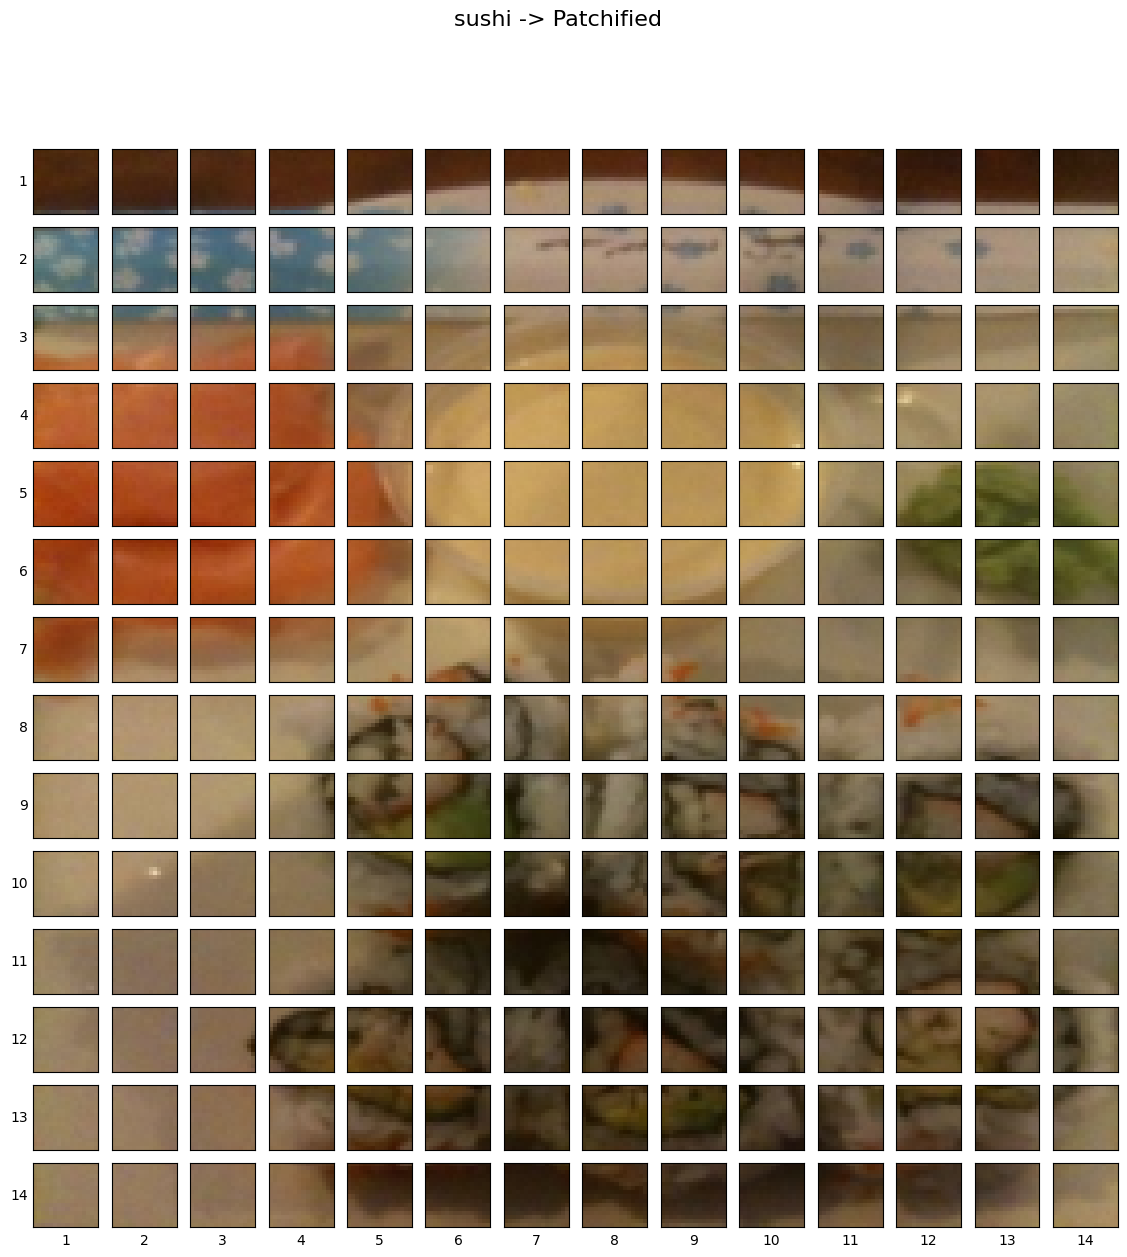

In [15]:
# Creating the patches for the whole image

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size,patch_size)): #iterate through height
    for j, patch_width in enumerate(range(0,img_size,patch_size)): #iterate through width
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                       patch_width:patch_width+patch_size,
                                       :])
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Creating image patches with CNN

By setting the kernel_size and stride parameters of a `torch.nn.Conv2d()` layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

![image](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

In [16]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)
                  

In [17]:
image_conv =conv2d(image.unsqueeze(0))
image_conv.shape

torch.Size([1, 768, 14, 14])

Showing features of index: [422, 432, 182, 427, 627]


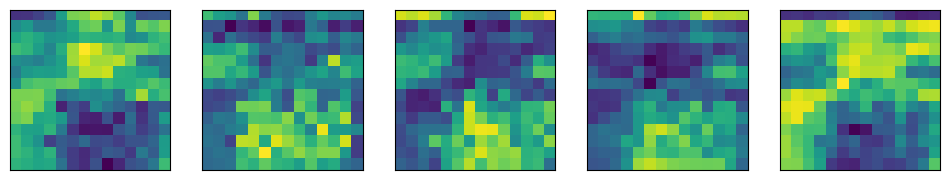

In [18]:
# plot random 5 convolution feature maps
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing features of index: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i , embd_idx in enumerate(random_indexes):
    img_feature_map = image_conv[:,  embd_idx, : , :]
    axs[i].imshow(img_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    

### Flattening the patch embedding 

In [19]:
#shape of image after conv2d will be [1,786,14,14]

flatten = nn.Flatten(start_dim = 2, # flatten height
                     end_dim=3)     # flatten width

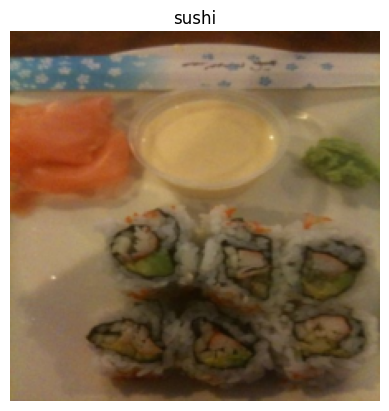

Orginal image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])
Desired flatten shape: torch.Size([1, 196, 768])


In [20]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()
print(f"Orginal image shape: {image.shape}")

# Turn image into feature maps
image_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_conv.shape}")

#Flatten the feature maps
image_conv_flatten = flatten(image_conv)
print(f"Flattened image feature map shape : {image_conv_flatten.shape}")

image_conv_flatten_reshaped = image_conv_flatten.permute(0,2,1)
print(f"Desired flatten shape: {image_conv_flatten_reshaped.shape}")



### Putting it all together for patch embedding

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # create a layer to turn an image into patches        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        #create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size ==0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        print(x_patched.shape)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)


In [22]:
set_seeds()

# Create an instance of patch embedding layer
patch_it = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)


print(f"Input image shape: {image.unsqueeze(0).shape}")

patch_embedded_image = patch_it(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
Output patch embedding shape: torch.Size([1, 196, 768])


### Creating the class token embedding

In [23]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token =  nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                            requires_grad=True)

print(class_token[:,:,:5])

tensor([[[1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [24]:
# now we need to concatenate the class token with the patch embeddings

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),dim=1)


print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
         [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
         ...,
         [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
         [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
         [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

In [25]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [26]:
#finally add the poistion embeddin with the patch and class token embedding

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7668, 1.0453, 0.8960,  ..., 1.0967, 0.9026, 1.0600],
         [0.7394, 1.0607, 0.9047,  ..., 1.0935, 0.9124, 1.0571],
         ...,
         [0.7255, 1.0205, 0.8679,  ..., 1.1757, 0.8989, 1.1285],
         [0.5948, 1.1081, 0.8483,  ..., 1.3164, 0.8206, 1.1142],
         [0.4368, 1.1053, 0.8563,  ..., 1.3965, 0.7551, 1.2157]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [27]:
# Equatino one alltogether
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


![image](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif)

## 3.6 Implementing Equation ( ii ) : Multi-Head Self-Attention (MSA)

Some resources for self attention and Transformers:<br>
1. [The Illustrated Transformers](http://jalammar.github.io/illustrated-transformer/)
2. [Illustrated Attention Post](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
3. [Attention is all you need paper](https://arxiv.org/abs/1706.03762)


In [28]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [29]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 3.7 Implementing Equation ( iii ) : Multi-Layer Perceptron (MLP)

In [30]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [31]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 3.8 Creating Transformer Encoder

In [32]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [33]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()



### Creating Transformer Encoder with PyTorch Transformer layer

In [34]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# 4. Create ViT model

In [35]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [36]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [37]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

torch.Size([1, 768, 14, 14])


tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [38]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

torch.Size([32, 768, 14, 14])


c:\Users\sachi\anaconda3\envs\dlwp\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# 5. Training ViT model

In [39]:
from going_modular import engine # type:ignore 

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([1, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8, 768, 14, 14])
torch.Size([8,

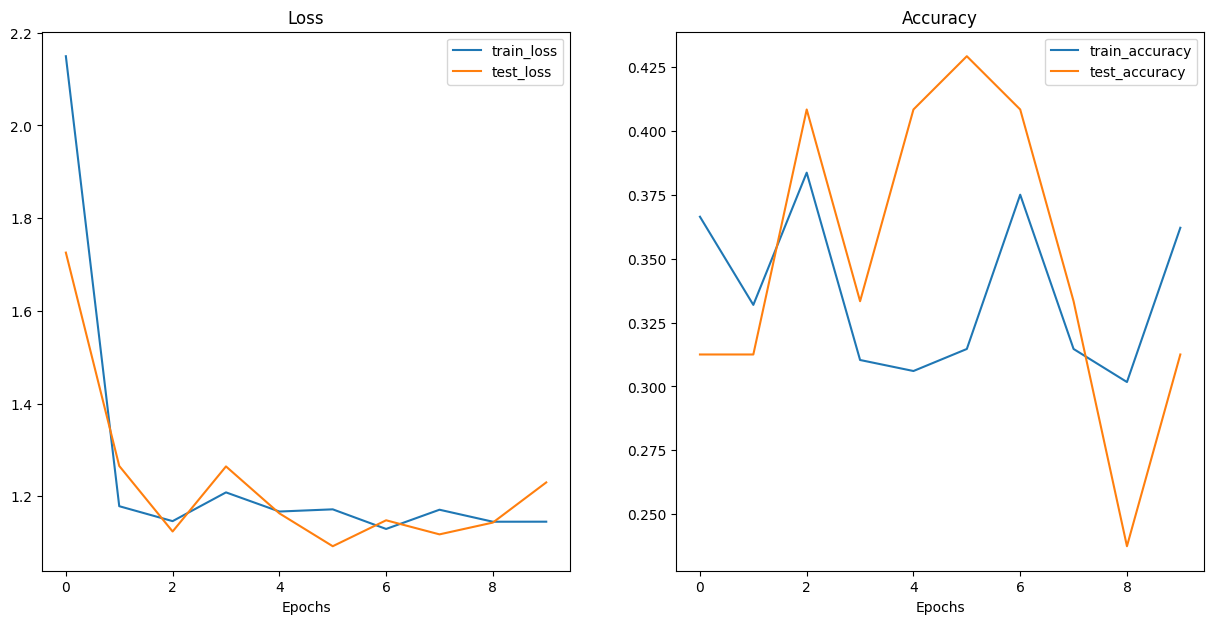

In [40]:
plot_loss_curves(results)

In [ ]:
# saving the model
from going_modular import utils #type:ignore

target = Path('Models')
name = "Self_trained_model.pth"
utils.save_model(model = vit,
                 target_dir=target,
                 model_name = name)

[INFO] Saving model to: Models\Self_trained_model.pth


# 6. Using Pretrained ViT model


In [15]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

### Creating the Transforms for the pretrained model for dataloader

In [16]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
# create dataloader
from going_modular import data_setup #type:ignore

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [18]:
# Trainig the pretrained model

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\sachi\anaconda3\envs\dlwp\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


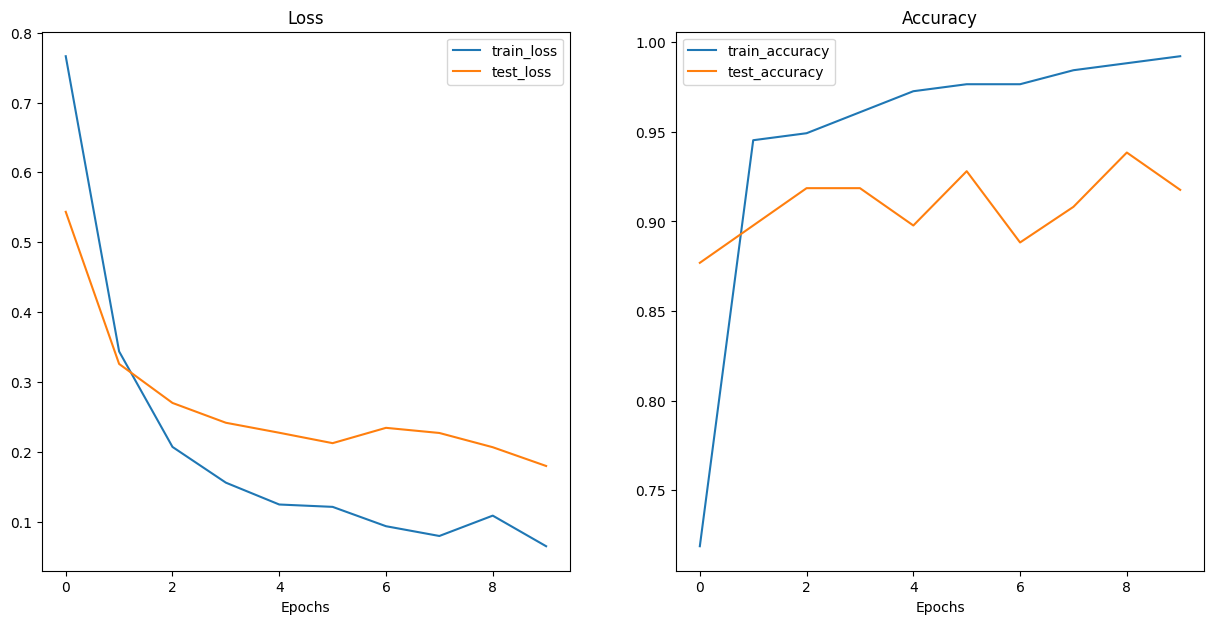

In [19]:
#plot the results

plot_loss_curves(pretrained_vit_results) 

In [24]:
#Save the pretrained model 
from going_modular import utils #type:ignore
target = Path('Models')
model_name = "pretrained_model.pth"

utils.save_model(model =pretrained_vit,
           target_dir= target,
           model_name = model_name
           )

[INFO] Saving model to: Models\pretrained_model.pth
